- Crear la matriz de dispersion
- Resolver el sistema

In [8]:
from scipy.sparse import diags, kron, identity
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray

FloatArray = NDArray[np.int16]

In [ ]:
data = scipy.io.loadmat('bordes1.mat')
u: FloatArray = data["bordes1"]


### Generamos la matriz dispersa 

In [9]:
from scipy.sparse import diags, kron, identity

N, M = u.shape
Dx = diags([-1, 4, -1], [-1, 0, 1], shape=(N, N))
Dy = diags([-1, 4, -1], [-1, 0, 1], shape=(M, M))

A = kron(identity(M), Dx) + kron(Dy, identity(N))
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 287040 stored elements and shape (57600, 57600)>

### Resolvamos el sistema

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg, bicgstab
from scipy.sparse.linalg import spilu

# 📌 Resolver el sistema A u = f con métodos iterativos

# Vector de términos independientes (bordes aplanados)
f_vector = u.flatten()

# 📌 1. Solución exacta con spsolve
u_exacta_vector = spsolve(A, f_vector)
u_exacta = u_exacta_vector.reshape((N, M))

# 📌 2. Jacobi (Usando método iterativo aproximado)
def jacobi(A, b, x0=None, tol=1e-6, max_iter=1000):
    """Método de Jacobi para resolver A x = b."""
    D = A.diagonal()
    R = A - np.diagflat(D)
    x = np.zeros_like(b) if x0 is None else x0.copy()

    for _ in range(max_iter):
        x_new = (b - R @ x) / D
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    return x

u_jacobi_vector = jacobi(A, f_vector)
u_jacobi = u_jacobi_vector.reshape((N, M))

# 📌 3. Gauss-Seidel (Método iterativo mejorado)
def gauss_seidel(A, b, x0=None, tol=1e-6, max_iter=1000):
    """Método de Gauss-Seidel para resolver A x = b."""
    x = np.zeros_like(b) if x0 is None else x0.copy()

    for _ in range(max_iter):
        x_old = x.copy()
        for i in range(len(b)):
            x[i] = (b[i] - A[i, :i] @ x[:i] - A[i, i+1:] @ x[i+1:]) / A[i, i]
        if np.linalg.norm(x - x_old) < tol:
            break

    return x

u_gauss_seidel_vector = gauss_seidel(A, f_vector)
u_gauss_seidel = u_gauss_seidel_vector.reshape((N, M))

# 📌 4. SOR (Successive Over-Relaxation)
def sor(A, b, omega=1.5, tol=1e-6, max_iter=1000):
    """Método SOR para resolver A x = b."""
    x = np.zeros_like(b)
    
    for _ in range(max_iter):
        x_old = x.copy()
        for i in range(len(b)):
            sigma = A[i, :i] @ x[:i] + A[i, i+1:] @ x[i+1:]
            x[i] = (1 - omega) * x[i] + (omega / A[i, i]) * (b[i] - sigma)
        if np.linalg.norm(x - x_old) < tol:
            break

    return x

u_sor_vector = sor(A, f_vector)
u_sor = u_sor_vector.reshape((N, M))

# 📌 5. Comparar las imágenes
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Lista de imágenes y títulos
imagenes = [u_exacta, u_jacobi, u_gauss_seidel, u_sor]
titulos = ["Solución Exacta (spsolve)", "Jacobi", "Gauss-Seidel", "SOR"]

# Mostrar cada imagen
for ax, img, title in zip(axes, imagenes, titulos):
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title(title)
    ax.axis("off")

plt.show()


MemoryError: Unable to allocate 24.7 GiB for an array with shape (57600, 57600) and data type float64

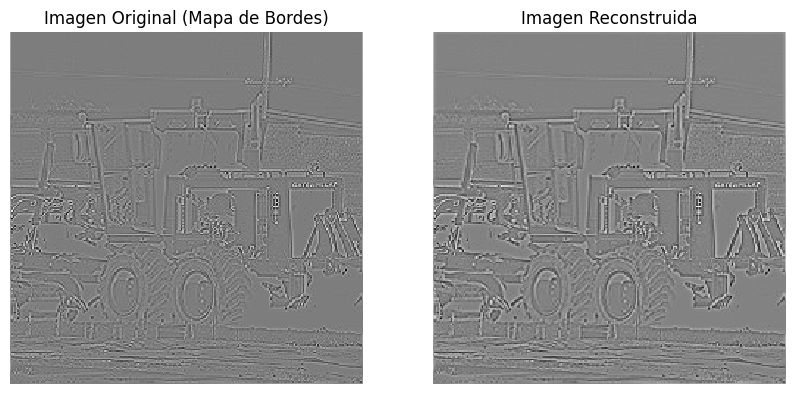

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(u, cmap='gray', interpolation='nearest')
axes[0].set_title("Imagen Original (Mapa de Bordes)")
axes[0].axis("off")  # Ocultar ejes

# Imagen reconstruida u
axes[1].imshow(u_reconstruida, cmap='gray', interpolation='nearest')
axes[1].set_title("Imagen Reconstruida")
axes[1].axis("off")  # Ocultar ejes

# Mostrar la figura
plt.show()